In [72]:
#imports
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import skfuzzy as fuzz
from scipy import stats



In [73]:
#read data
data=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [74]:

# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_data_info = pd.DataFrame({'Missing_Values': missing_values, 'Missing_Percentage': missing_percentage})
missing_data_info = missing_data_info.sort_values(by='Missing_Percentage', ascending=False)
print("Columns with the highest percentage of missing values:")
print(missing_data_info.head())


Columns with the highest percentage of missing values:
                          Missing_Values  Missing_Percentage
age                                    0                 0.0
anaemia                                0                 0.0
creatinine_phosphokinase               0                 0.0
diabetes                               0                 0.0
ejection_fraction                      0                 0.0


In [75]:
#handle data and outliers and check for duplicates
numerical_cols = data.select_dtypes(include=[np.number]).columns
data['age'] = np.clip(data['age'], 1, 100)
data['age'] = data['age'].astype(int)
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows))

Number of duplicate rows: 0


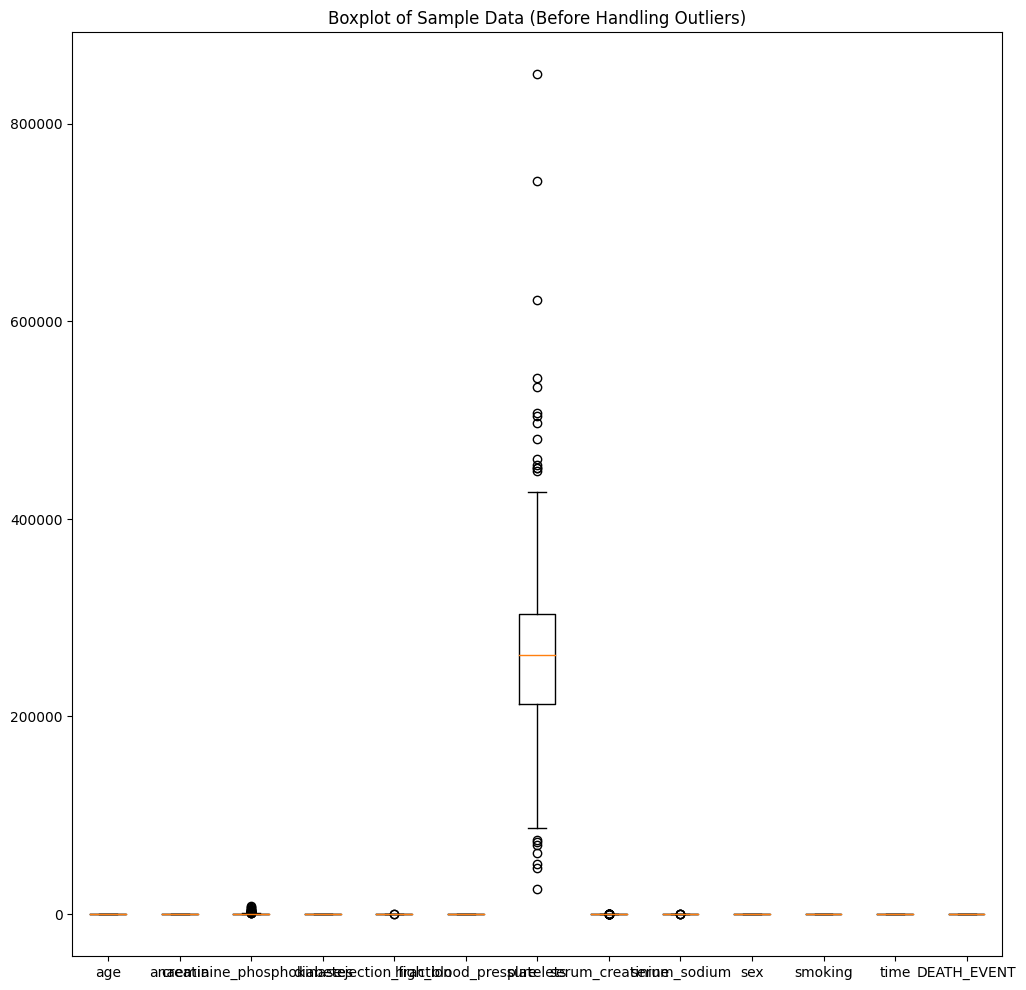

C:\Users\Abdelrahman Abdullah\AppData\Local\Temp\ipykernel_6708\1669946942.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60.82943143812709' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[(df[column] < lower_threshold) | (df[column] > upper_threshold), column] = mean
C:\Users\Abdelrahman Abdullah\AppData\Local\Temp\ipykernel_6708\1669946942.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.431438127090301' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[column] < lower_threshold) | (df[column] > upper_threshold), column] = mean
C:\Users\Abdelrahman Abdullah\AppData\Local\Temp\ipykernel_6708\1669946942.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '581.839464

Outliers in age:
Empty DataFrame
Columns: [age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, smoking, time, DEATH_EVENT]
Index: []

Outliers in anaemia:
Empty DataFrame
Columns: [age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, smoking, time, DEATH_EVENT]
Index: []

Outliers in creatinine_phosphokinase:
      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
1    55.0      0.0                      7861         0                 38   
38   60.0      0.0                      2656         1                 30   
46   51.0      0.0                      1380         0                 25   
52   60.0      0.0                      3964         1                 62   
60   45.0      0.0                      7702         1                 25   
72   85.0      0.0                      5882         0  

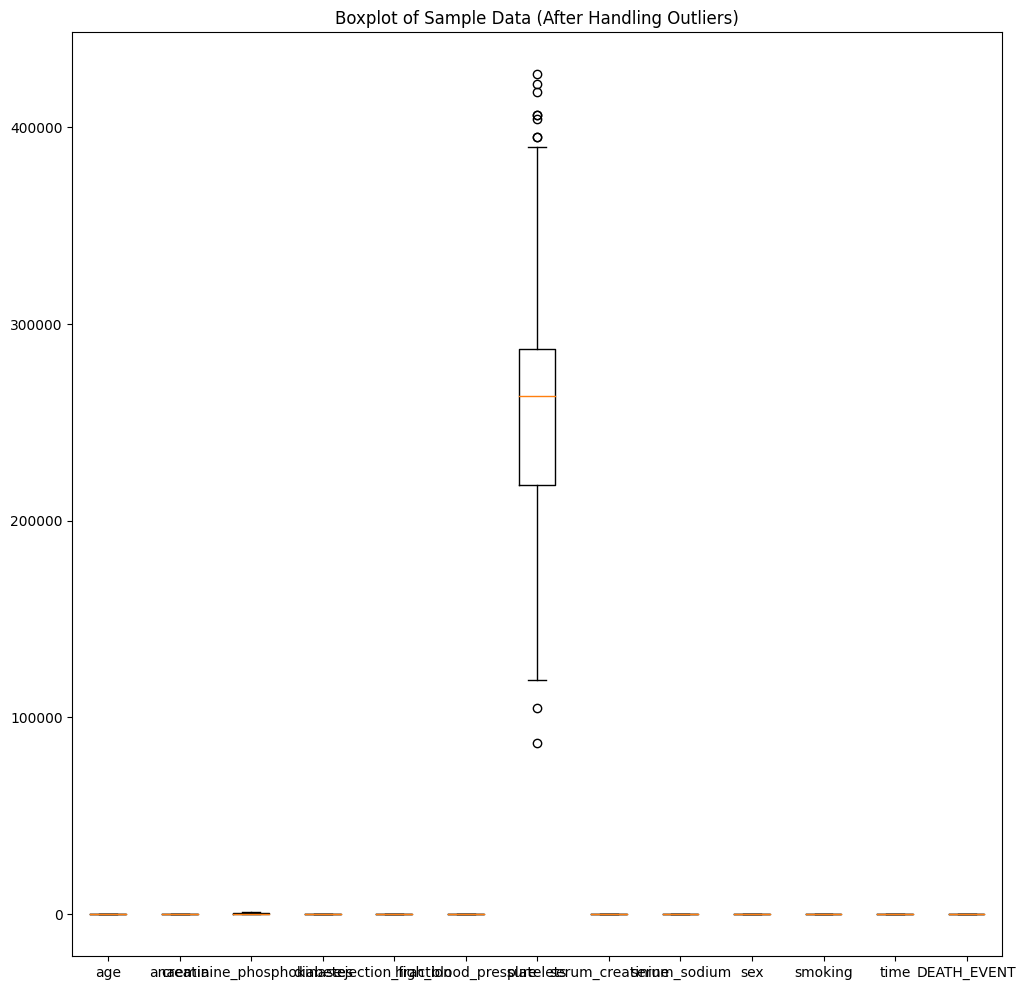

In [76]:


def handle_outliers(df, column):
    # Calculate quartiles and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define threshold for outliers
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_threshold) | (df[column] > upper_threshold)]
    
    # Replace outliers with mean
    mean = df[column].mean()
    df.loc[(df[column] < lower_threshold) | (df[column] > upper_threshold), column] = mean
    
    return df, outliers


numerical_data = data.select_dtypes(include=[np.number])

# Plot boxplots before handling outliers
plt.figure(figsize=(12, 12))
plt.boxplot(numerical_data.values, labels=numerical_data.columns)
plt.title('Boxplot of Sample Data (Before Handling Outliers)')
plt.show()

# Iterate over numerical columns and handle outliers
numerical_columns = data.select_dtypes(include=np.number).columns
for column in numerical_columns:
    data, outliers = handle_outliers(data, column)
    print(f"Outliers in {column}:\n{outliers}\n")
numerical_data = data.select_dtypes(include=[np.number])
# Plot boxplots after handling outliers
plt.figure(figsize=(12, 12))
plt.boxplot(numerical_data.values, labels=numerical_data.columns)
plt.title('Boxplot of Sample Data (After Handling Outliers)')
plt.show()

In [77]:
#describe and analyze data
print('Descriptive Statistics for Train Dataset','\n', data.describe())
print('\n','Median:\n', data[numerical_cols].median(), '\n', 'Mode:\n', data.mode().iloc[0], '\n')

Descriptive Statistics for Train Dataset 
               age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.829431    0.431438                356.476069    0.418060   
std     11.894997    0.496107                273.994009    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               1211.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           37.836680             0.351171  255279.161754   
std            11.431887             0.478136   65577.637397   
min            14.000000             0.000000   87000.000000 

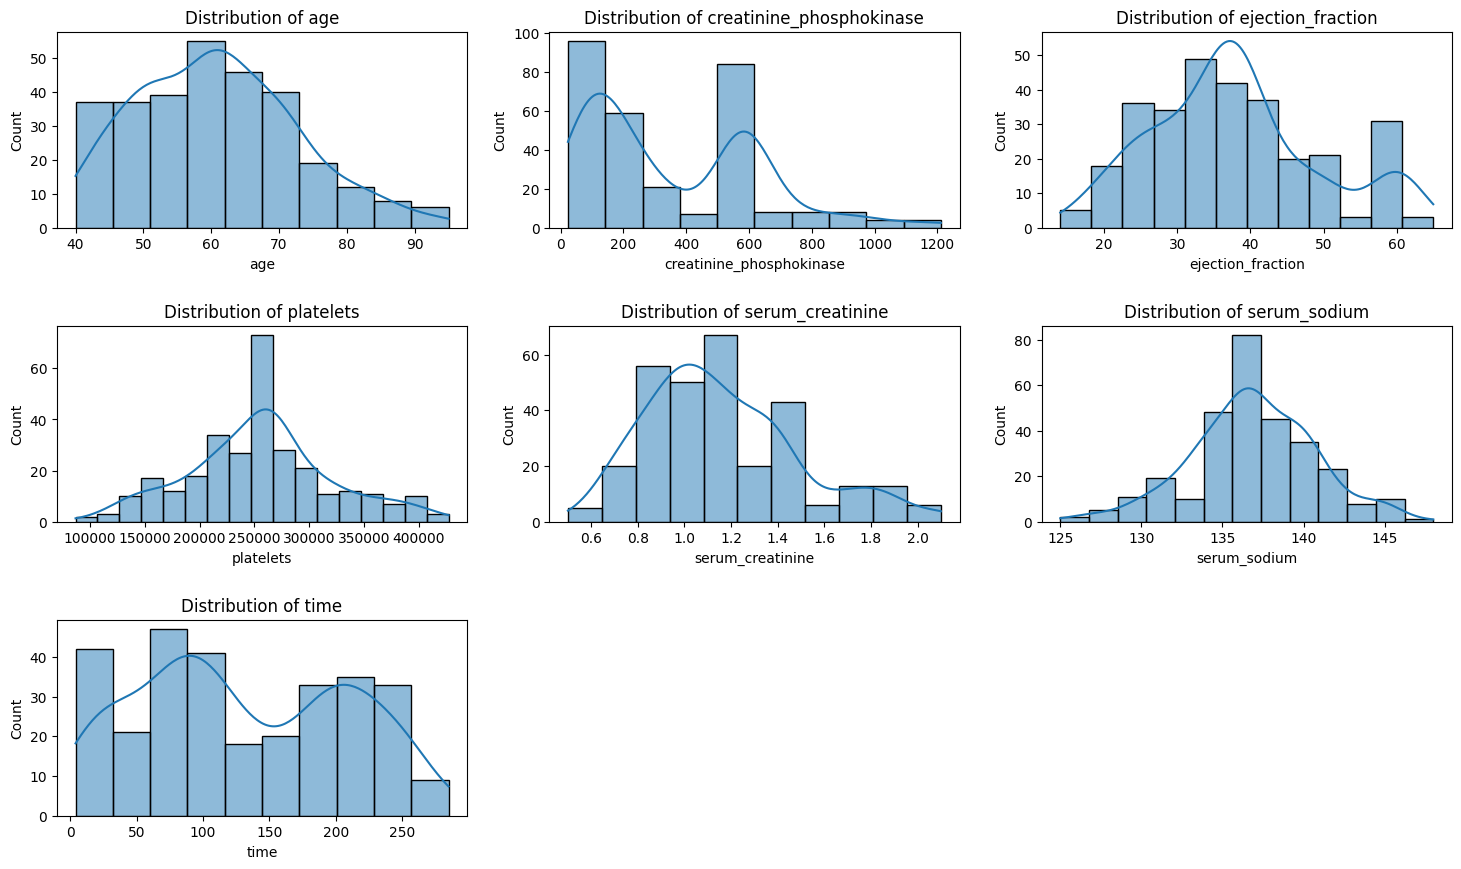

In [78]:
# Visualize distributions of numerical variables
plt.figure(figsize=(18, 14))
plt.subplots_adjust(hspace=0.5)
numerical_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
for i, var in enumerate(numerical_vars, start=1):
    plt.subplot(4, 3, i)  
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
plt.show()



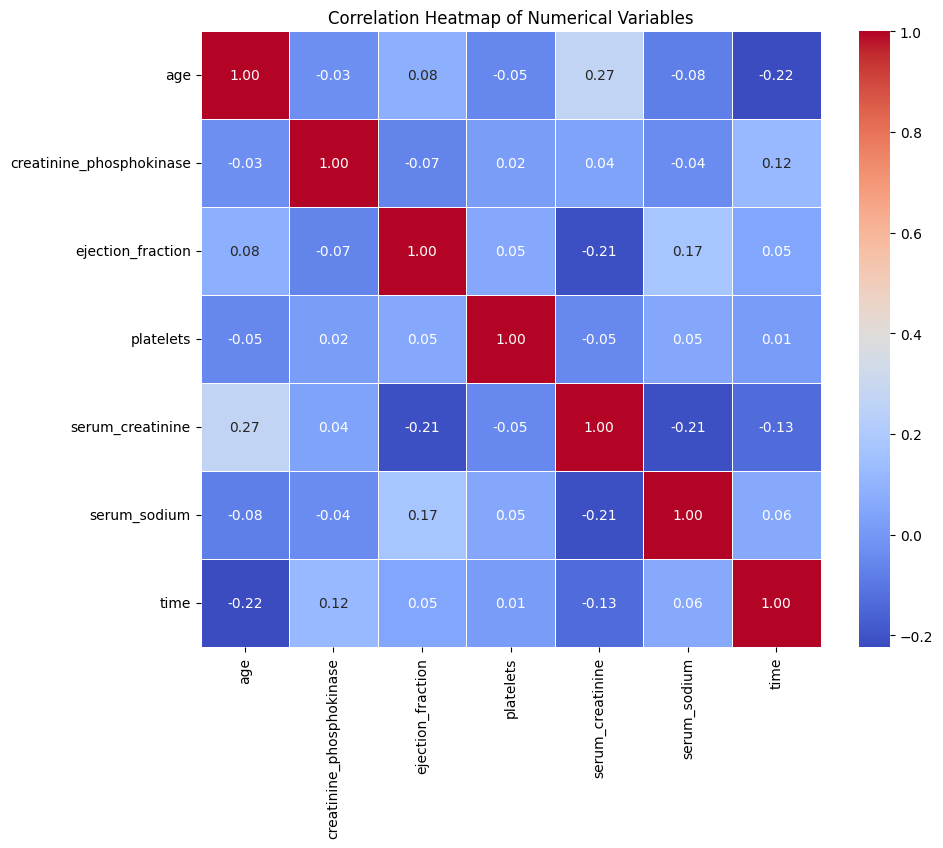

In [79]:
# Visualize correlations between numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()



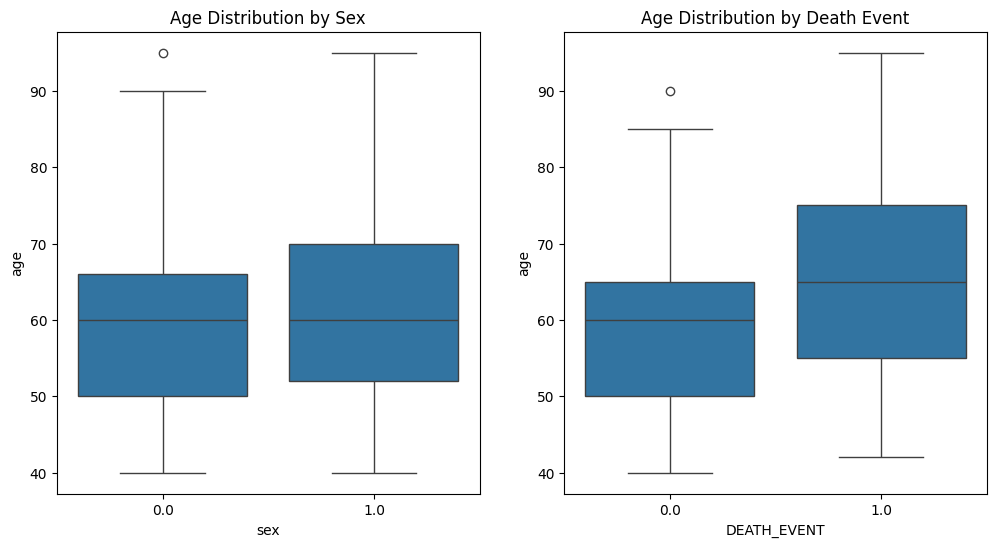

In [80]:
# Boxplot for categorical variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='sex', y='age', data=data)
plt.title('Age Distribution by Sex')

plt.subplot(1, 2, 2)
sns.boxplot(x='DEATH_EVENT', y='age', data=data)
plt.title('Age Distribution by Death Event')
plt.show()

In [81]:
#scale the data (already all numerical no encoding needed)
'''scaler = StandardScaler()
data= scaler.fit_transform(data)''' #commented because it decreases the accuracy


'scaler = StandardScaler()\ndata= scaler.fit_transform(data)'

In [82]:
#K-medoids
max_clusters = 20 
silhouette_scores = []
#check for best cluster
for n_clusters in range(2, max_clusters + 1):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmedoids.fit_predict(data)
    silhouette_avg = metrics.silhouette_score(data, cluster_labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  
print("Optimal number of clusters:", optimal_num_clusters)
#use best k
k=optimal_num_clusters
k_medoid=KMedoids(n_clusters=k).fit(data)
clusters=k_medoid.cluster_centers_
labels=k_medoid.labels_

print('Labels :' , labels)
print('Clusters :', clusters)

for j in range (k):
    for i in range (len(data)):
        if (labels[i]==j):
            print('Clusters',j,':patient ',i)


#evaluate model
silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)

davies_bouldin_score = metrics.davies_bouldin_score(data, labels)

print("Silhouette Score:", silhouette_score)
print("Calinski-Harabasz Index:", calinski_harabasz_score)
print("Davies-Bouldin Index:", davies_bouldin_score)


Optimal number of clusters: 5
Labels : [2 2 0 3 4 3 0 2 2 1 1 2 0 2 1 2 2 0 3 0 2 4 4 1 2 0 3 2 0 3 2 1 4 4 3 3 3
 4 4 4 2 0 0 3 3 4 2 2 0 1 0 1 2 1 2 2 3 3 4 2 1 3 2 1 2 0 3 2 2 2 1 0 2 0
 2 3 4 3 2 4 4 2 3 0 4 1 0 4 3 0 2 4 2 3 4 3 2 2 4 3 4 2 0 3 4 2 2 3 4 2 4
 3 2 1 4 0 2 2 3 2 3 0 3 0 3 3 2 4 2 3 2 2 2 4 3 2 0 4 3 3 2 1 4 3 4 2 3 2
 3 3 3 2 0 2 3 3 2 2 3 1 2 0 2 2 4 3 3 2 2 4 2 4 0 3 2 4 0 0 2 2 4 3 2 3 3
 1 0 1 3 2 1 4 2 0 0 3 2 2 2 2 2 1 3 3 2 1 3 3 2 2 1 0 2 2 4 3 1 0 2 1 2 3
 1 0 2 2 3 0 3 2 2 0 2 4 4 1 2 0 2 2 2 2 2 3 2 2 4 2 4 3 1 3 2 3 2 4 4 2 3
 4 3 2 3 3 0 1 2 0 4 3 2 3 3 3 0 1 4 2 3 2 3 2 3 2 2 4 2 2 2 1 3 0 1 0 0 2
 2 0 1]
Clusters : [[5.40000000e+01 1.00000000e+00 4.27000000e+02 0.00000000e+00
  3.80836120e+01 1.00000000e+00 1.51000000e+05 1.39387960e+00
  1.37000000e+02 0.00000000e+00 0.00000000e+00 1.96000000e+02
  1.00000000e+00]
 [4.50000000e+01 0.00000000e+00 3.08000000e+02 1.00000000e+00
  6.00000000e+01 1.00000000e+00 3.77000000e+05 1.00000000e+00
  1.36000000e+

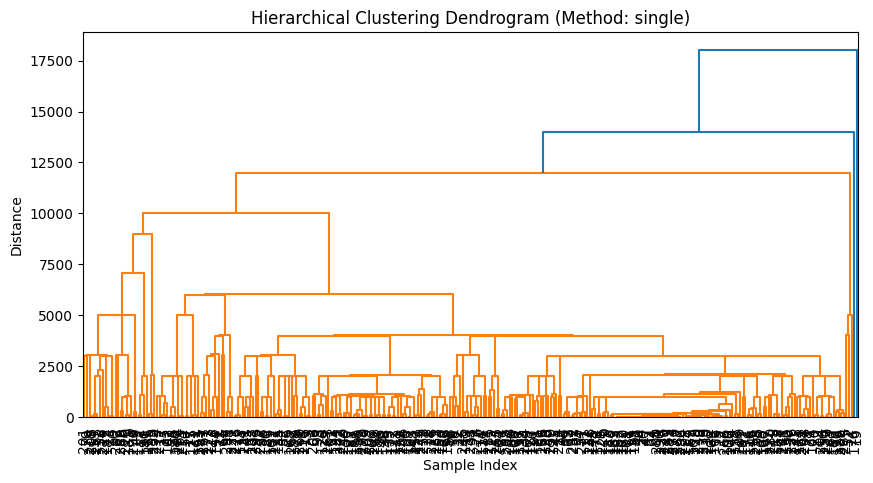

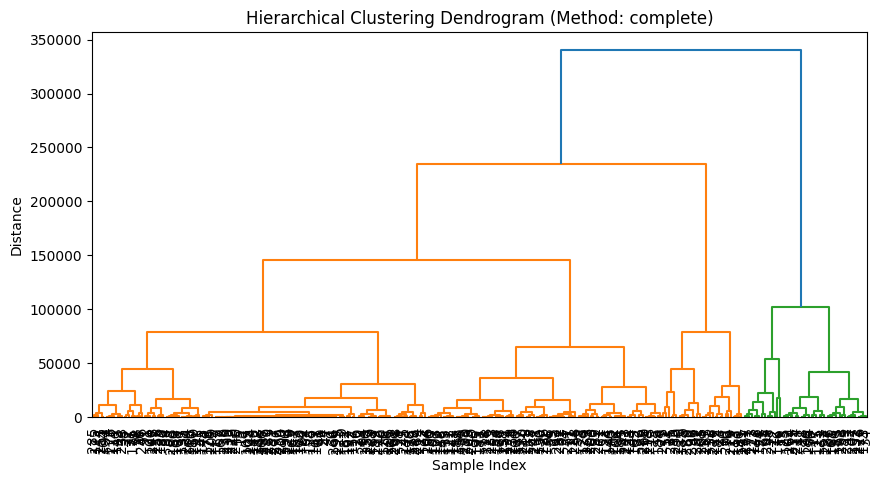

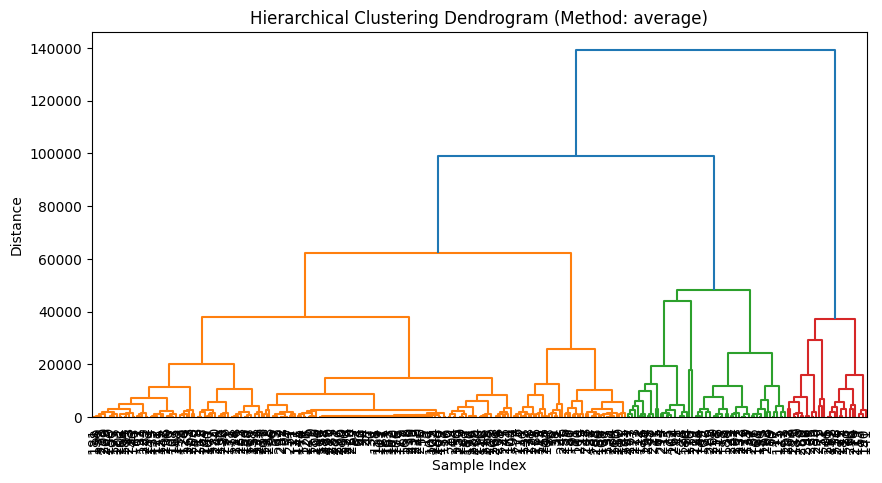

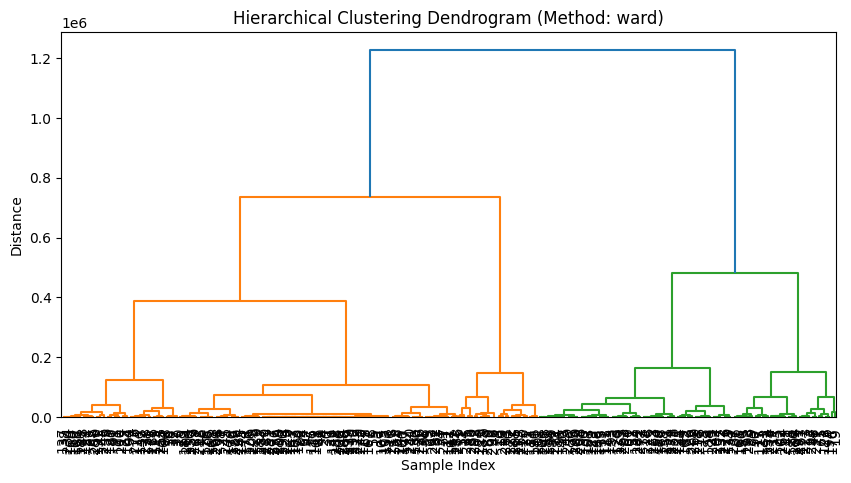

Best linkage method: ward
Silhouette score: 0.6270949323650562
Calinski-Harabasz Index: 1285.4503057058505
Davies-Bouldin Index: 0.4430375156730718


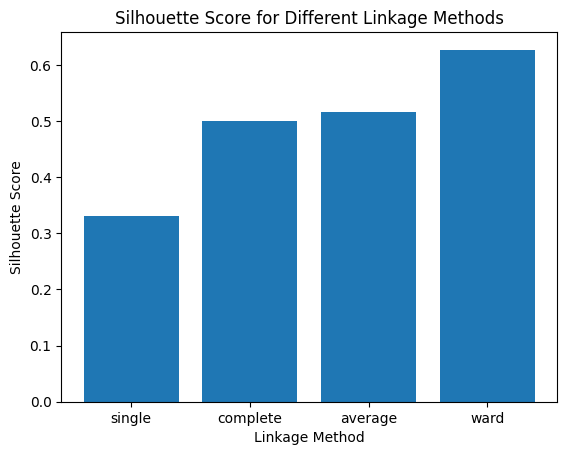

In [88]:
#hierarchical
linkage_methods = ['single', 'complete', 'average', 'ward']

def cluster_and_score(X, linkage_method):
    Z = linkage(X, method=linkage_method,metric='euclidean')
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram (Method: {})'.format(linkage_method))
    dendrogram(Z,orientation='top',distance_sort='descending',leaf_font_size=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    cluster_labels = fcluster(Z, optimal_num_clusters, criterion='maxclust')  
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(X, cluster_labels)
    davies_bouldin_score = metrics.davies_bouldin_score(X, cluster_labels)
    return silhouette_avg, calinski_harabasz_score, davies_bouldin_score

silhouette_scores = {}
calinski_harabasz_scores = {}
davies_bouldin_scores = {}
# Test each linkage method
for method in linkage_methods:
    silhouette_scores[method],calinski_harabasz_scores[method], davies_bouldin_scores[method] = cluster_and_score(data, method)

# Find the best linkage method
best_linkage_method = max(silhouette_scores, key=silhouette_scores.get)
best_score = silhouette_scores[best_linkage_method]
best_calinski_harabasz = calinski_harabasz_scores[best_linkage_method]
best_davies_bouldin = davies_bouldin_scores[best_linkage_method]

print("Best linkage method:", best_linkage_method)
print("Silhouette score:", best_score)
print("Calinski-Harabasz Index:", best_calinski_harabasz)
print("Davies-Bouldin Index:", best_davies_bouldin)


# Plot the silhouette scores
plt.bar(range(len(silhouette_scores)), list(silhouette_scores.values()), align='center')
plt.xticks(range(len(silhouette_scores)), list(silhouette_scores.keys()))
plt.xlabel('Linkage Method')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Linkage Methods')
plt.show()

Optimal number of clusters: 5
Silhouette Score: 0.6269335437842574
Calinski-Harabasz Index: 1285.8164559649315
Davies-Bouldin Index: 0.4434473137294426


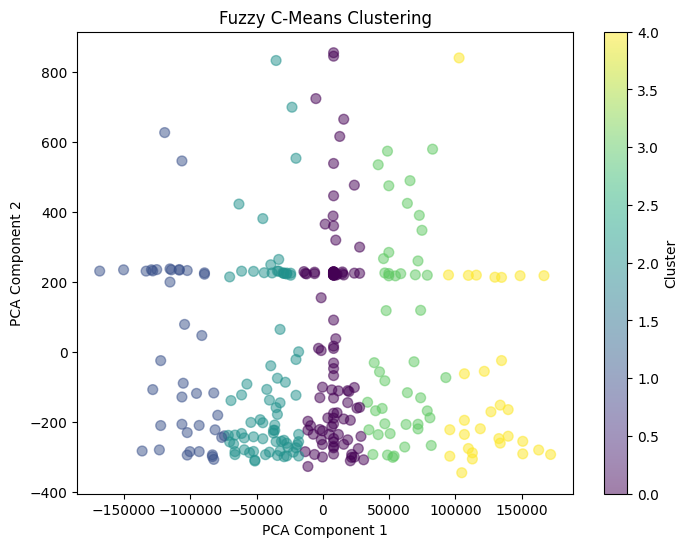

In [84]:
#Fuzzy
# Reduce dimensionality to 2 (for easier visualization)
pca = PCA(n_components=2)  
data_pca = pca.fit_transform(data)

# check for best number of clusters
max_clusters = 10
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, n_clusters, 2, error=0.005, maxiter=1000, init=None
    )
    labels = np.argmax(u, axis=0)
    silhouette_avg = metrics.silhouette_score(data, labels)
    silhouette_scores.append(silhouette_avg)

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_num_clusters)

# Apply Fuzzy C-Means clustering with the optimal number of clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, optimal_num_clusters, 2, error=0.005, maxiter=1000, init=None
)
labels = np.argmax(u, axis=0)

#evaluate
silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)

davies_bouldin_score = metrics.davies_bouldin_score(data, labels)

print("Silhouette Score:", silhouette_score)
print("Calinski-Harabasz Index:", calinski_harabasz_score)
print("Davies-Bouldin Index:", davies_bouldin_score)
# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Fuzzy C-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()
